## Zipf's Law and US Metro Population Growth
*Jeremy A. Seibert*

<p><img style="float: left;margin:5px 20px 5px 1px" src="http://image.wikifoundry.com/image/1/f3Kj_GjHdYH-6OvJHobYbQ10037/GW161H212"></p>

George Zipf (Pictured) was a lingustic from Harvard in the early 20th century who postulated and found that within languages certian words are used in a higher frequency, while the rest are hardly ever used. Though initially intended only for use in analyzing word frequencies, the generalized form known as the Zipf-Madelbrot Law and its associated have been found throughout many unrelated diciplines. 

As it turns out Zipf's Law explains and interesting question in Urban Economics, City growth. In this notebook, we will be showing the (Rank-Size) distributions of the United States Metropolitan Area's Population, and how Zipf's law explains the population distribution of Metro Areas.

If Zipf's law holds then it would state that the correlation coeffecient of between Metro Rank and the Metro Population would be approiximately -1.0. 


In [3]:
#Gather the tools
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

## 1. Metro Rank-Size Distribution

Using Population Data collected from the US Census Bureau we can begin to construct the Rank-Size Distribution. In this notebook we are using the 2017 Population estimates as our base year. The methodology included in the repo explains how the Census Bureau derives their estimates for the populations in the metro areas. 

As a quick overview, they use the most recent census year (2000, 2010, 2020, etc.) as their base year and in conjuction with other population-based information, and then derive the estimate.

Population Base + Births - Deaths + Migration = Population Estimate

I would be remiss if I did not point out that there is obviously room for error in this calculation. However for our use case in this notebook the error is really a non-issue. Also within this notebook, where ever there is a metion of "city" this can be thought of synonomously as an agglomeration entity charaterized by the Census Metropolitan Statistical Areas (Metros).

In [4]:
#Read in the Population Estimates
file = './Dataset/US_Metro_Pop_Est.csv'
pop = pd.read_csv(file,usecols=list(range(3,15)),encoding='latin-1')

#Filter Metro-Only
pop = pop.loc[pop['LSAD'] == 'Metropolitan Statistical Area'].set_index('NAME')

#Filter for 2017
pop_17 = pop[['POPESTIMATE2017']].sort_values(by='POPESTIMATE2017', ascending=False)

#Rank the Metros
pop_17['Rank'] = range(1,len(pop_17.index)+1)

# Define Functions to Convert Values
log_pop = lambda x: np.log(x)
log_rank = lambda x: np.log(x) + 1

# Convert to Log values
pop_17['LogRank'] = pop_17['Rank'].apply(log_rank)
pop_17['LogPop'] = pop_17['POPESTIMATE2017'].apply(log_pop)

#Show the DataFrame
pop_17.head(10)

,POPESTIMATE2017,Rank,LogRank,LogPop
NAME,,,,
"New York-Newark-Jersey City, NY-NJ-PA",20320876,1,1.000000,16.827159
"Los Angeles-Long Beach-Anaheim, CA",13353907,2,1.693147,16.407320
"Chicago-Naperville-Elgin, IL-IN-WI",9533040,3,2.098612,16.070274
"Dallas-Fort Worth-Arlington, TX",7399662,4,2.386294,15.816945
"Houston-The Woodlands-Sugar Land, TX",6892427,5,2.609438,15.745934
"Washington-Arlington-Alexandria, DC-VA-MD-WV",6216589,6,2.791759,15.642732
"Miami-Fort Lauderdale-West Palm Beach, FL",6158824,7,2.945910,15.633396
"Philadelphia-Camden-Wilmington, PA-NJ-DE-MD",6096120,8,3.079442,15.623163
"Atlanta-Sandy Springs-Roswell, GA",5884736,9,3.197225,15.587872


## 2. Find the Regression Coeffecient

In works done by Paul Krugman in 1996 and Gabaix in 1999 they found that regressing the size of the metro's against the rank of metro's yeilded a coeffecient very close to -1.0. Let's see in the next steps if we can do the same. 


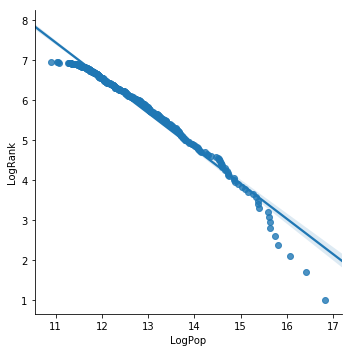

R^2: 0.9741162743633364
Coeffecient: [[-0.88246969]]


In [5]:
# Import LinearRegression
from sklearn.linear_model import LinearRegression

# Create the regressor: reg
reg = LinearRegression()

# Create arrays for features and target variable
y = pop_17['LogRank']
X = pop_17['LogPop']

# Reshape X and y
y = y.reshape(-1,1)
X_LogPop = X.reshape(-1,1)

# Create the prediction space
prediction_space = np.linspace(min(X_LogPop), max(X_LogPop)).reshape(-1,1)

# Fit the model to the data
reg.fit(X_LogPop, y)

# Compute predictions over the prediction space: y_pred
y_pred = reg.predict(prediction_space)

#Visualize the Distribution
sns.lmplot(x='LogPop',y='LogRank', data=pop_17)
plt.show()

# Print R^2 
print('R^2: {}'.format(reg.score(X_LogPop, y)))
print('Coeffecient: {}'.format(reg.coef_))

## 3. Not Quite -1.0 , What is different?

In the regression above we obtained a coeffecient value close to -0.9, which is not quite the -1.0 that was reported by Krugman and Gabaix. We see that within the middle section of the distribution the fit is near perfect, this section includes metro's such as Ashville, NC and Lexington, KY, however towards the tails we find that the fit is not so nice. Gabaix in his 1999 paper provides an explaiantion for the smaller metros, in that they are more succeptible to industry-level shocks due to a lack of indusrty diversity (Gabaix, 1999).

Back to the regression, What did we miss? The key here is that both Krugman and Gabaix both ran their regressions on the top-135 largest metros, rather than all 382 metros (Gabiax,1999) (Krugman,1996). 

Let's re-run our regression and check out the result.

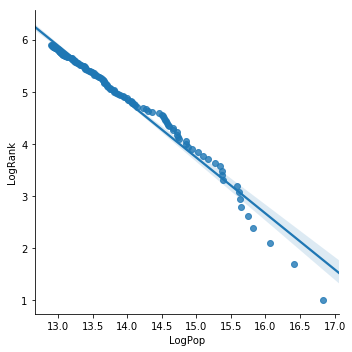

R^2: 0.9762999583583303
Coeffecient: [[-1.07343662]]


In [6]:
# Import LinearRegression
from sklearn.linear_model import LinearRegression

# Create the regressor: reg
reg = LinearRegression()

# Create arrays for features and target variable
y = pop_17['LogRank'][:134]
X = pop_17['LogPop'][:134]

# Reshape X and y
y = y.reshape(-1,1)
X_LogPop = X.reshape(-1,1)

# Create the prediction space
prediction_space = np.linspace(min(X_LogPop), max(X_LogPop)).reshape(-1,1)

# Fit the model to the data
reg.fit(X_LogPop, y)

# Compute predictions over the prediction space: y_pred
y_pred = reg.predict(prediction_space)

#Visualize the Distribution
sns.lmplot(x='LogPop',y='LogRank', data=pop_17[:134])
plt.show()

# Print R^2 
print('R^2: {}'.format(reg.score(X_LogPop, y)))
print('Coeffecient: {}'.format(reg.coef_))

## 4. One more try!

We didn't exactly get the -1.0 coeffecient with the Top 135 either, but it we are pretty close. In this run we got a correlation coeffcient of approximately 1.1%. This means that we can confirm that somewhere between using all of the metro areas at -0.9 and the top-135 at -1.1, there exists a line of best fit that closely appoximates -1.0. 

If we look at the Top-203 largest metros we find the arbitrialy best fit to rank-size regression coeffecient of -1.0 for the data from 2017. 

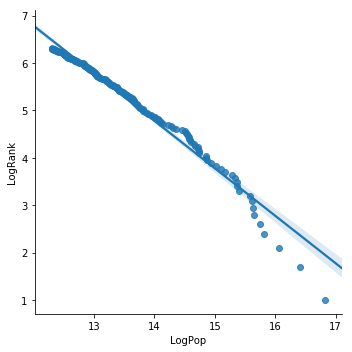

R^2: 0.977705640850799
Coeffecient: [[-1.00146052]]


In [7]:
# Import LinearRegression
from sklearn.linear_model import LinearRegression

# Create the regressor: reg
reg = LinearRegression()

# Create arrays for features and target variable
y = pop_17['LogRank'][:202]
X = pop_17['LogPop'][:202]

# Reshape X and y
y = y.reshape(-1,1)
X_LogPop = X.reshape(-1,1)

# Create the prediction space
prediction_space = np.linspace(min(X_LogPop), max(X_LogPop)).reshape(-1,1)

# Fit the model to the data
reg.fit(X_LogPop, y)

# Compute predictions over the prediction space: y_pred
y_pred = reg.predict(prediction_space)

#Visualize the Distribution
sns.lmplot(x='LogPop',y='LogRank', data=pop_17[:202])
plt.show()

# Print R^2 
print('R^2: {}'.format(reg.score(X_LogPop, y)))
print('Coeffecient: {}'.format(reg.coef_))

## Eureka! 

There is our -1.0 regression coeffecient! 

Through all of this fun, and several beautiful R^2 and coeffecient values, we found that US Metro Areas do closely follow the distribution that George Zipfs found almost 90 years ago.

This notebook could be re-run using (2016,2015,2014,etc.) which are contained in the csv file, just change the pandas population column and run!


### Citations

* Gabiax, X., ZIPF’S LAW FOR CITIES: AN EXPLANATION (Cambridge, MA, 1999). [Actual Paper](http://www.casa.ucl.ac.uk/mike-michigan-april1/mike%27s%20stuff/attach/Gabaix.pdf)

* Krugman, P., The Self-Organizing Economy (Cambridge, MA: Blackwell, 1996a)., ‘‘Confronting the Urban Mystery,’’ 

* [Census Population Estimation Methodology](./Metro_Est_Methodology.pdf)
